In [2]:
# 必要なパッケージをインポート
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from statsmodels.graphics.tsaplots import plot_acf


In [3]:
import pymc as pm
import arviz as az
import pytensor.tensor as pt

In [4]:
print(np.__version__)
print(pm.__version__)
print(az.__version__)

1.23.5
5.7.2
0.15.1


## データの準備など

In [5]:
# データ用意
parray1 = pd.read_csv(f"../data/4-2-1-fish-num-3.csv")
df1 = pd.DataFrame(parray1)
print(df1.shape)
display(df1.head())

parray2 = pd.read_csv(f"../data/4-3-1-fish-num-4.csv")
df2 = pd.DataFrame(parray2)
print(df2.shape)
display(df2.head())

(100, 4)


,fish_num,weather,temperature,human
0,1,cloudy,6.0,A
1,7,cloudy,20.6,B
2,12,cloudy,27.5,C
3,0,cloudy,8.5,D
4,0,cloudy,3.1,E


(94, 3)


,fish_num,temperature,human
0,2,12.7,A
1,6,13.7,B
2,9,15.7,C
3,5,19.1,D
4,11,12.0,E


## ランダム切片モデル

### 可視化

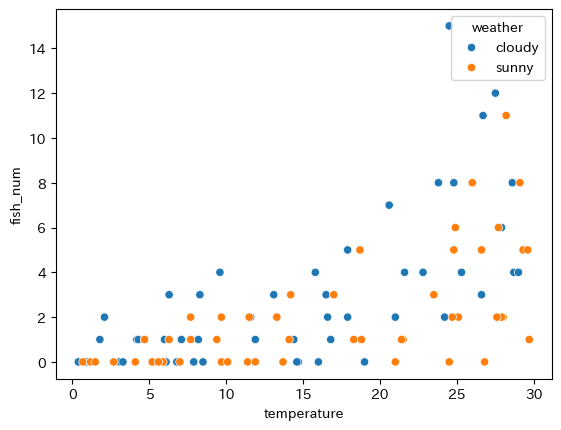

In [6]:
# データの可視化(天気ごと)
fig, ax = plt.subplots()
ax = sns.scatterplot(x = parray1["temperature"], y = parray1["fish_num"],
                     hue = parray1["weather"])

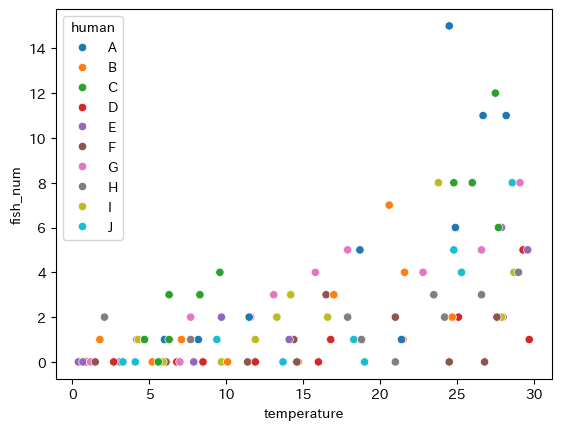

In [7]:
# データの可視化(humanごと)
fig, ax = plt.subplots()
ax = sns.scatterplot(x = parray1["temperature"], y = parray1["fish_num"],
                     hue = parray1["human"])

### ベイズ推論

In [8]:
# データの準備
y = parray1["fish_num"].values
weather = pd.get_dummies(df1["weather"], dtype=int, drop_first=True).values.reshape(-1)
temperature = df1["temperature"].values
cl = pd.Categorical(df1["human"]).codes

print(y[:5])
print(weather[:5])
print(temperature[:5])
print(df1["human"][:5])
print(cl[:5])

[ 1  7 12  0  0]
[0 0 0 0 0]
[ 6.  20.6 27.5  8.5  3.1]
0    A
1    B
2    C
3    D
4    E
Name: human, dtype: object
[0 1 2 3 4]


In [9]:
# # 確率モデルの定義
# model = pm.Model()

# with model:
#     # 観測値をConstantDataとして定義
#     y_data = pm.Data("y_data", y, mutable=True)
#     weather_data = pm.Data("weather_data", weather, mutable=True)
#     temperature_data = pm.Data("temperature_data", temperature, mutable=True)

#     # パラメータを確率変数として定義
#     b0 = pm.Normal("b0", mu=0, sigma=10000)
#     b_w = pm.Normal("b_w", mu=0, sigma=10000)
#     b_t = pm.Normal("b_t", mu=0, sigma=10000)

#     # 目的変数の期待値を確率変数として定義
#     exp_lambda_ = pm.Deterministic("exp_lambda_", 
#                                    pt.exp(b_w * weather_data + b_t * temperature_data + b0))

#     # 観測値を持つ確率変数として定義
#     y_obs = pm.Poisson("y_obs", mu=exp_lambda_, observed=y_data)

# g = pm.model_to_graphviz(model)
# display(g)

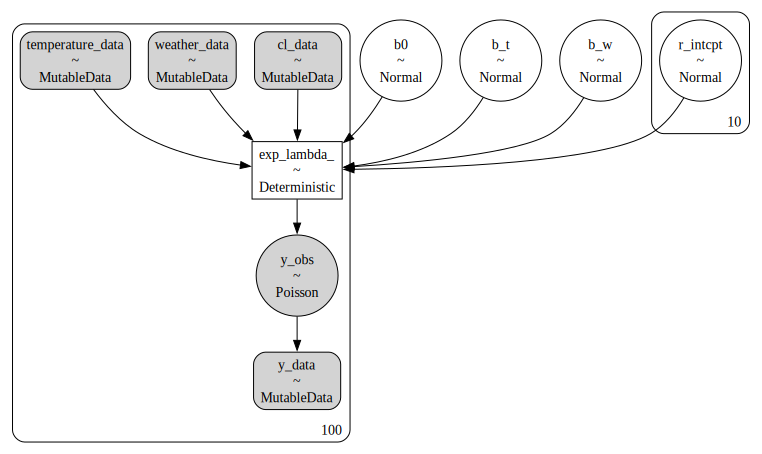

In [10]:
# 確率モデルの定義
model = pm.Model()

with model:
    # 観測値をConstantDataとして定義
    y_data = pm.Data("y_data", y, mutable=True)
    weather_data = pm.Data("weather_data", weather, mutable=True)
    temperature_data = pm.Data("temperature_data", temperature, mutable=True)

    # クラス変数を定義
    cl_data = pm.Data("cl_data", cl, mutable=True)

    # パラメータを確率変数として定義
    b0 = pm.Normal("b0", mu=0, sigma=100)
    b_w = pm.Normal("b_w", mu=0, sigma=100)
    b_t = pm.Normal("b_t", mu=0, sigma=100)

    # ランダム切片効果を定義
    r_intcpt = pm.Normal("r_intcpt", mu=0, sigma=100, shape=(10, ))

    # 目的変数の期待値を確率変数として定義
    exp_lambda_ = pm.Deterministic("exp_lambda_", 
                                   pt.exp(b_w * weather_data + b_t * temperature_data + b0 + r_intcpt[cl_data]))

    # 観測値を持つ確率変数として定義
    y_obs = pm.Poisson("y_obs", mu=exp_lambda_, observed=y_data)

g = pm.model_to_graphviz(model)
display(g)

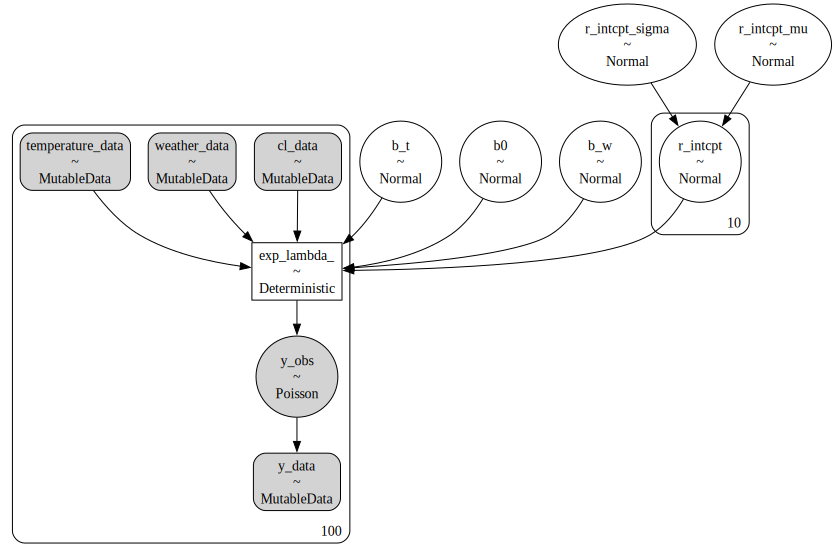

In [11]:
# 確率モデルの定義
model = pm.Model()

with model:
    # 観測値をConstantDataとして定義
    y_data = pm.Data("y_data", y, mutable=True)
    weather_data = pm.Data("weather_data", weather, mutable=True)
    temperature_data = pm.Data("temperature_data", temperature, mutable=True)

    # クラス変数を定義
    cl_data = pm.Data("cl_data", cl, mutable=True)

    # パラメータを確率変数として定義
    b0 = pm.Normal("b0", mu=0, sigma=100)
    b_w = pm.Normal("b_w", mu=0, sigma=100)
    b_t = pm.Normal("b_t", mu=0, sigma=100)

    # ランダム切片効果を定義
    r_intcpt_mu = pm.Normal("r_intcpt_mu", mu=0, sigma=100)
    r_intcpt_sigma = pm.Normal("r_intcpt_sigma", mu=0, sigma=100)
    r_intcpt = pm.Normal("r_intcpt", mu=r_intcpt_mu, sigma=r_intcpt_sigma, shape=(10, ))

    # 目的変数の期待値を確率変数として定義
    exp_lambda_ = pm.Deterministic("exp_lambda_", 
                                   pt.exp(b_w * weather_data + b_t * temperature_data + b0 + r_intcpt[cl_data]))

    # 観測値を持つ確率変数として定義
    y_obs = pm.Poisson("y_obs", mu=exp_lambda_, observed=y_data)

g = pm.model_to_graphviz(model)
display(g)

In [16]:
# パラメータのMCMCサンプリング
with model:
    idata1 = pm.sample(
        chains = 1,
        tune = 2000,
        draws = 1000,
        random_seed = 42,
        # target_accept = 0.99
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [b0, b_w, b_t, r_intcpt_mu, r_intcpt_sigma, r_intcpt]


Sampling 1 chain for 2_000 tune and 1_000 draw iterations (2_000 + 1_000 draws total) took 377 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


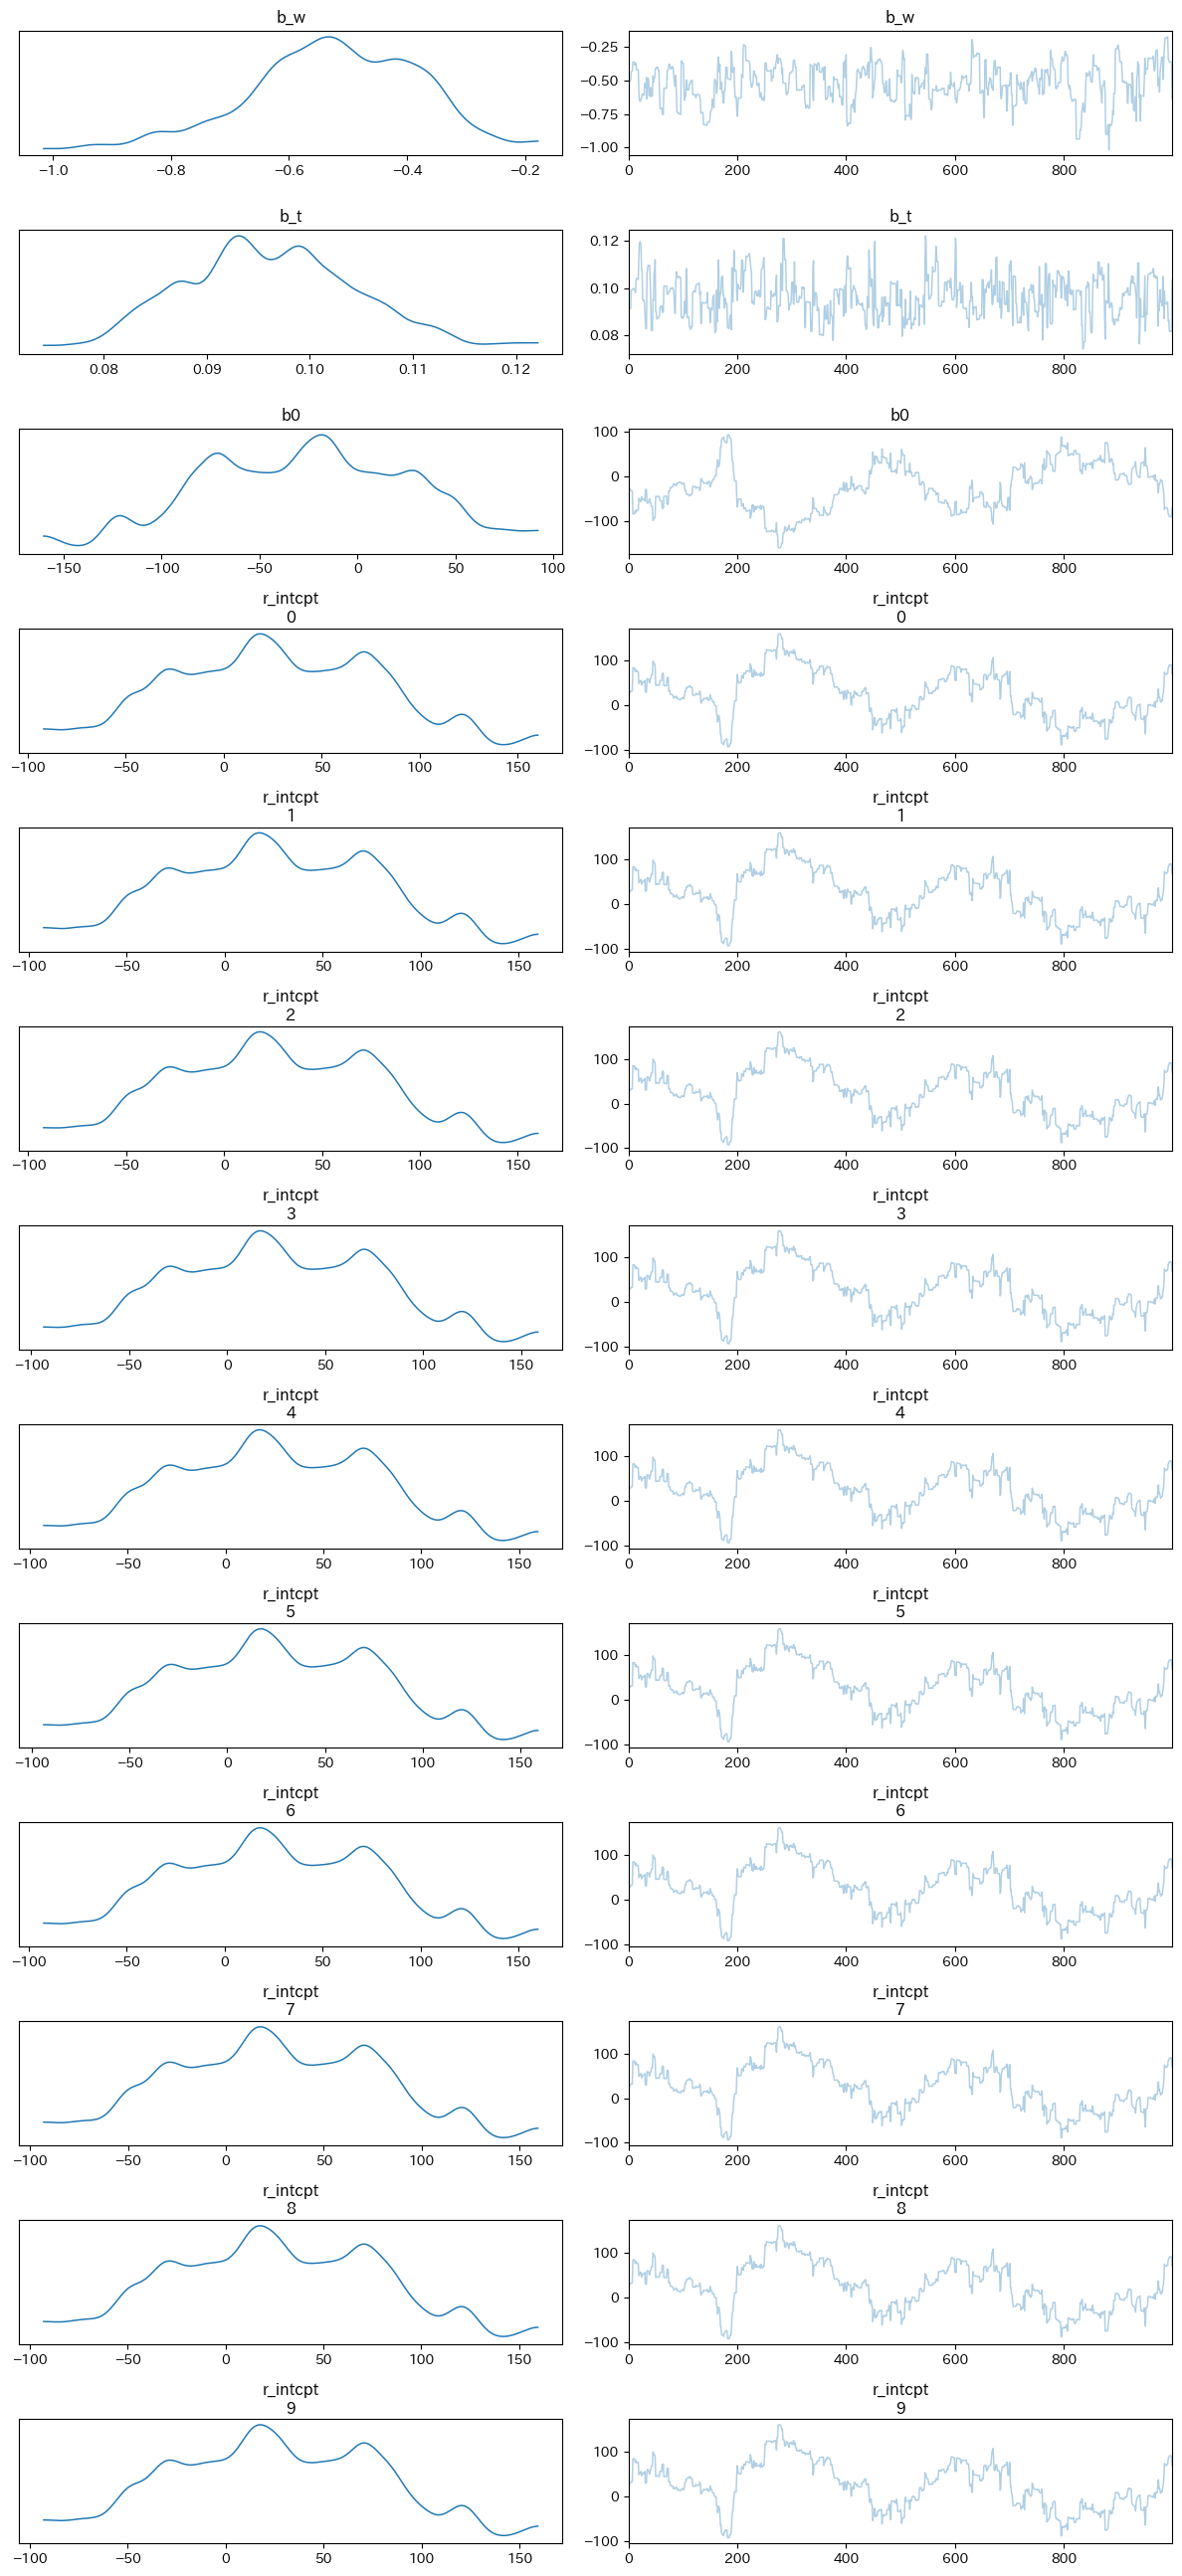

In [17]:
# 事後分布の可視化
az.plot_trace(idata1, compact=False, var_names=["b_w", "b_t", "b0", "r_intcpt"])
# az.plot_trace(idata1, compact=False, var_names=["b_w", "b_t", "b0"])
plt.tight_layout();

In [18]:
# MCMCサンプルの統計量
az.summary(idata1, var_names=["b_w", "b_t", "b0", "r_intcpt"])
# az.summary(idata1, var_names=["b_w", "b_t", "b0"])

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_w,-0.523,0.141,-0.838,-0.309,0.015,0.011,92.0,109.0,NaN
b_t,0.096,0.008,0.081,0.112,0.001,0.001,129.0,262.0,NaN
b0,-25.869,51.623,-127.572,54.824,16.325,11.898,10.0,20.0,NaN
r_intcpt[0],25.780,51.597,-55.073,126.821,16.320,11.894,10.0,20.0,NaN
r_intcpt[1],25.111,51.599,-55.869,126.602,16.318,11.893,10.0,20.0,NaN
r_intcpt[2],25.706,51.597,-57.012,124.911,16.320,11.895,10.0,20.0,NaN
r_intcpt[3],24.415,51.577,-56.565,125.499,16.311,11.887,10.0,20.0,NaN
r_intcpt[4],24.903,51.588,-58.131,123.959,16.315,11.891,10.0,20.0,NaN
r_intcpt[5],24.295,51.612,-58.618,123.584,16.313,11.889,10.0,20.0,NaN
r_intcpt[6],25.480,51.602,-57.482,124.758,16.321,11.896,10.0,20.0,NaN


## ランダム係数モデル